<a href="https://colab.research.google.com/github/MPolyakman/CNN-for-tisuse-classification/blob/main/solution_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [72]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc',
    'mytrain': '1h4EUhn4cAzT0lYx6Dlwu9Ew3oxAy0Ckd',
    'mytest': '1KV6bp65OS1YM9XcgMEQUDPZ8od04qiwz'
}

In [ ]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

import torch
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torchvision.transforms as T
from PIL import Image

# Новый раздел

# аугментация данных

Применяются только аугментации отзеркаливания, зума и поворотов так как изменение насыщенности или формы может сделать гистограмму похожей на другой тип ткани

In [55]:
from torchvision.transforms import v2

def random_augment(img):
    _, h, w = img.shape
    choice = random.randint(0, 1)

    if choice == 0:
        return T.functional.hflip(img)

    elif choice == 1:
        return T.functional.vflip(img)


In [56]:
import os
class Dataset:

    def __init__(self, name, local_path = None):
        self.name = name
        self.is_loaded = False

        if local_path is not None:
            # Use uploaded/local file
            if not os.path.exists(local_path):
                raise FileNotFoundError(f"Local dataset file not found: {local_path}")
            output_path = local_path
            print(f'Loading dataset {self.name} from local file: {local_path}')
        else:
            # Download from Google Drive
            drive_id = DATASETS_LINKS.get(name)
            if not drive_id:
                raise ValueError(f"Dataset '{name}' not found in DATASETS_LINKS.")
            url = "https://drive.google.com/uc?id=" + drive_id
            output_path = f'{name}.npz'
            if not os.path.exists(output_path):
                print(f"Downloading dataset {name} from Google Drive...")
                gdown.download(url, output_path, quiet=False)
            else:
                print(f"Dataset {name} already exists locally. Skipping download.")

        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(output_path, allow_pickle=True)
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

In [57]:
import random

class HistologyTorchDataset(TorchDataset):
        """
        Обёртка над Dataset для использования с PyTorch.

        base_dataset: экземпляр Dataset('train'), Dataset('train_small'), etc.
        transform:    функция/объект, преобразующий изображение (PIL.Image -> torch.Tensor).

        """
        def __init__(self, base_dataset, transform=None):
            self.base = base_dataset
            # Минимальный transform по умолчанию:
            # np.uint8 [0, 255] -> float32 [0.0, 1.0]
            self.transform = transform or T.ToTensor()

        def __len__(self):
            # Размер датасета
            return len(self.base.images)

        def __getitem__(self, idx):
            """
            Возвращает (image_tensor, label) для PyTorch.
            image_tensor: torch.Tensor формы [3, H, W]
            label: int
            """
            img, label = self.base.image_with_label(idx)  # img: np.ndarray (H, W, 3)
            #img = Image.fromarray(img)                    # в PIL.Image
            img = self.transform(img)                     # в torch.Tensor

            if random.random() < 0.4:
                img = random_augment(img)

            return img, label

In [58]:
"""
if "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:
    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")
else:
    print("Пример использования PyTorch-обёртки над Dataset")

    base_train = Dataset('train_tiny')

    # Создаём PyTorch-совместимый датасет
    train_ds = HistologyTorchDataset(base_train)

    # DataLoader автоматически создаёт батчи и перемешивает данные
    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)

    # Берём один батч и выводим информацию
    images_batch, labels_batch = next(iter(train_loader))

    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]
    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]
    print("Пример меток:", labels_batch[:10].tolist())

    print("Тип images_batch:", type(images_batch))
    print("Тип labels_batch:", type(labels_batch))
"""

'\nif "HistologyTorchDataset" not in globals() or HistologyTorchDataset is None:\n    print("PyTorch не установлен или обёртка недоступна — пример пропущен.")\nelse:\n    print("Пример использования PyTorch-обёртки над Dataset")\n\n    base_train = Dataset(\'train_tiny\')\n\n    # Создаём PyTorch-совместимый датасет\n    train_ds = HistologyTorchDataset(base_train)\n\n    # DataLoader автоматически создаёт батчи и перемешивает данные\n    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)\n\n    # Берём один батч и выводим информацию\n    images_batch, labels_batch = next(iter(train_loader))\n\n    print("Форма батча изображений:", tuple(images_batch.shape))  # [batch, 3, 224, 224]\n    print("Форма батча меток:", tuple(labels_batch.shape))        # [batch]\n    print("Пример меток:", labels_batch[:10].tolist())\n\n    print("Тип images_batch:", type(images_batch))\n    print("Тип labels_batch:", type(labels_batch))\n'

**Метрики**

In [59]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

# Модель

In [77]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.num_classes = len(TISSUE_CLASSES)

        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, self.num_classes)

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool1(x)

        x = self.enc2(x)
        x = self.pool2(x)

        x = self.bottleneck(x)

        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.fc(x)

        return x

    def save_weights(self, path):
        torch.save(self.state_dict(), path)

    def load_weights(self, path, device=None):
        self.load_state_dict(torch.load(path, map_location=device, weights_only=False))

    def test_on_dataset(self, dataset: Dataset, limit=None):
        # you can upgrade this code if you want to speed up testing using batches
        predictions = []
        n = dataset.n_files if not limit else int(dataset.n_files * limit)
        for img in tqdm(dataset.images_seq(n), total=n):
            predictions.append(self.test_on_image(img))
        return predictions

    def test_on_image(self, img):
        # todo: replace this code
        prediction = self.forward(img)
        return prediction

    def load(self, link, device):
        output = 'model.pth'
        gdown.download(link, output, quiet=False)
        self.load_weights(output, device)

# Валидация на всей эпохе

In [61]:
def validate(model, val_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return Metrics.accuracy(all_labels, all_preds), Metrics.accuracy_balanced(all_labels, all_preds)

In [62]:
import datetime

def write_to_log(str_content):
    current_datetime = datetime.datetime.now()
    datetime_str = current_datetime.strftime("%d-%m_%H-%M")

    filename = f"log_{datetime_str}.txt"

    with open(filename, 'w', encoding='utf-8') as file:
        file.write(str_content)

    print(f"Successfully wrote to {filename}")
    return os.path.abspath(filename)

In [ ]:
#write_to_log("test")

# функция обучения

In [81]:
import copy
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_with_early_stopping(
        model_class,
        train_loader,
        val_loader,
        device,
        max_epochs=50,
        patience=5,
        LOAD_FROM_CHECKPOINT=False):



    best_acc = 0
    best_b_acc = 0
    epochs_no_improve = 0
    best_epoch = 0
    best_model_w = None

    LR = 1e-4

    model = model_class().to(device)

    if LOAD_FROM_CHECKPOINT:
        try:
            model.load_weights('best_model.pth', device)
        except:
            print("LOADING FAILED")
            exit(0)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []
    val_accuracies = []
    val_balanced_accuracies = []

    log_str = f'learning started: max epochs = {max_epochs}, patience = {patience}, Learning rate = {LR}\n\n'



    for epoch in range(max_epochs):
        model.train()
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs}", leave=False)

        epoch_loss = 0.0
        correct_train = 0
        total_train = 0


        for images, labels in train_loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        val_acc, val_acc_b = validate(model, val_loader, device)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        val_balanced_accuracies.append(val_acc_b)

        str = f"\nEpoch {epoch + 1} - Val Acc: {val_acc:.4f} Val_acc_b: {val_acc_b}\n"
        tqdm.write(str)
        log_str += str

        if (val_acc > best_acc):
            best_acc = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            best_model_w = copy.deepcopy(model.state_dict())
            str = f"\nImprovement detected (acc: {val_acc:.4f} acc_balanced: {val_acc_b:.4f}| Final {best_acc:.4f})\n"
            tqdm.write(str)
            log_str += str

            torch.save(best_model_w, "best_model.pth")
        else:
            epochs_no_improve += 1

        if epochs_no_improve > patience:
            tqdm.write("the end")
            break

    if best_model_w is not None:
        model.load_state_dict(best_model_w)

    str = (f'best result is {best_acc} best epoch is {best_epoch + 1}\n')
    tqdm.write(str)
    log_str += str

    epochs_trained = len(train_losses)
    plt.figure(figsize=(12, 4))

    # Plot 1: Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses, label='Train Loss', color='tab:red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies, label='Train Acc', marker='o')
    plt.plot(range(1, epochs_trained + 1), val_accuracies, label='Val Acc', marker='s')
    plt.plot(range(1, epochs_trained + 1), val_balanced_accuracies, label='Val Acc (Balanced)', linestyle='--', marker='^')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.suptitle(f'Training Summary (Best Val Acc: {best_acc:.4f} @ Epoch {best_epoch + 1})', y=1.02)
    plt.savefig("training_curve.png", dpi=150, bbox_inches='tight')
    plt.show(block=False)

    write_to_log(log_str)

    return model


#**Main part**


**Грузим датасет по ссылке**

In [ ]:
from torch.utils.data import random_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = HistologyTorchDataset(Dataset('mytrain'))

Downloading...
From (original): https://drive.google.com/uc?id=1h4EUhn4cAzT0lYx6Dlwu9Ew3oxAy0Ckd
From (redirected): https://drive.google.com/uc?id=1h4EUhn4cAzT0lYx6Dlwu9Ew3oxAy0Ckd&confirm=t&uuid=f117c452-940e-4f89-859a-4327ccf2407d
To: /content/mytrain.npz
100%|██████████| 2.10G/2.10G [00:30<00:00, 68.3MB/s]


Loading dataset mytrain from npz.
Done. Dataset mytrain consists of 18000 images.


Создаем даталоадеры с валидацией (20 процентов от тренировачного набора)

In [82]:
BATCH_SIZE = 64
#except:
#    print("fail")
#    from google.colab import files
#    uploaded = files.upload()
#    from google.colab import files
 #   uploaded = files.upload()
 #   train_dataset = HistologyTorchDataset(Dataset(name="train_small", local_path="train_small.npz"))

dataset_size = len(train_dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### **Обучение с ранней остановкой и чекпоинтами**

In [65]:
LOAD_CHECKPOINT = False

**Можно использовать эту переменную если нужно воостановить веса после прерывания обучения**

Epoch 1/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 1 - Val Acc: 0.6766 Val_acc_b: 0.6843604180145588


Improvement detected (acc: 0.6766 acc_balanced: 0.6844| Final 0.6766)



Epoch 2/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 2 - Val Acc: 0.7437 Val_acc_b: 0.7494090951924681


Improvement detected (acc: 0.7437 acc_balanced: 0.7494| Final 0.7437)



Epoch 3/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 3 - Val Acc: 0.7566 Val_acc_b: 0.7619342079616727


Improvement detected (acc: 0.7566 acc_balanced: 0.7619| Final 0.7566)



Epoch 4/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 4 - Val Acc: 0.7763 Val_acc_b: 0.7817827783819508


Improvement detected (acc: 0.7763 acc_balanced: 0.7818| Final 0.7763)



Epoch 5/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 5 - Val Acc: 0.7939 Val_acc_b: 0.7989451600225128


Improvement detected (acc: 0.7939 acc_balanced: 0.7989| Final 0.7939)



Epoch 6/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 6 - Val Acc: 0.8020 Val_acc_b: 0.8023368778984482


Improvement detected (acc: 0.8020 acc_balanced: 0.8023| Final 0.8020)



Epoch 7/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 7 - Val Acc: 0.8386 Val_acc_b: 0.8401186803826748


Improvement detected (acc: 0.8386 acc_balanced: 0.8401| Final 0.8386)



Epoch 8/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 8 - Val Acc: 0.8488 Val_acc_b: 0.8515343786413531


Improvement detected (acc: 0.8488 acc_balanced: 0.8515| Final 0.8488)



Epoch 9/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 9 - Val Acc: 0.8427 Val_acc_b: 0.8489007975315621



Epoch 10/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 10 - Val Acc: 0.8237 Val_acc_b: 0.826047050280651



Epoch 11/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 11 - Val Acc: 0.8664 Val_acc_b: 0.8655629875804879


Improvement detected (acc: 0.8664 acc_balanced: 0.8656| Final 0.8664)



Epoch 12/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 12 - Val Acc: 0.8664 Val_acc_b: 0.8676754146155944



Epoch 13/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 13 - Val Acc: 0.9119 Val_acc_b: 0.9118108895937515


Improvement detected (acc: 0.9119 acc_balanced: 0.9118| Final 0.9119)



Epoch 14/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 14 - Val Acc: 0.9051 Val_acc_b: 0.9061999020666204



Epoch 15/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 15 - Val Acc: 0.8441 Val_acc_b: 0.8451519476520829



Epoch 16/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 16 - Val Acc: 0.9003 Val_acc_b: 0.901763563244072



Epoch 17/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 17 - Val Acc: 0.9247 Val_acc_b: 0.9261116223242605


Improvement detected (acc: 0.9247 acc_balanced: 0.9261| Final 0.9247)



Epoch 18/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 18 - Val Acc: 0.9227 Val_acc_b: 0.9235153076890364



Epoch 19/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 19 - Val Acc: 0.9383 Val_acc_b: 0.9397884669109177


Improvement detected (acc: 0.9383 acc_balanced: 0.9398| Final 0.9383)



Epoch 20/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 20 - Val Acc: 0.9017 Val_acc_b: 0.9014559311476256



Epoch 21/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 21 - Val Acc: 0.9417 Val_acc_b: 0.9426382383738002


Improvement detected (acc: 0.9417 acc_balanced: 0.9426| Final 0.9417)



Epoch 22/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 22 - Val Acc: 0.9417 Val_acc_b: 0.9425230826086197



Epoch 23/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 23 - Val Acc: 0.9376 Val_acc_b: 0.9393818931288157



Epoch 24/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 24 - Val Acc: 0.8990 Val_acc_b: 0.903184623832156



Epoch 25/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 25 - Val Acc: 0.9532 Val_acc_b: 0.9542999210011492


Improvement detected (acc: 0.9532 acc_balanced: 0.9543| Final 0.9532)



Epoch 26/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 26 - Val Acc: 0.9044 Val_acc_b: 0.9079994350437625



Epoch 27/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 27 - Val Acc: 0.9173 Val_acc_b: 0.9194122983851825



Epoch 28/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 28 - Val Acc: 0.8936 Val_acc_b: 0.8981642286121715



Epoch 29/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 29 - Val Acc: 0.9295 Val_acc_b: 0.9313710266427714



Epoch 30/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 30 - Val Acc: 0.9478 Val_acc_b: 0.9496382952785746



Epoch 31/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 31 - Val Acc: 0.9424 Val_acc_b: 0.9448545071186957



Epoch 32/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 32 - Val Acc: 0.9525 Val_acc_b: 0.9540484834909739



Epoch 33/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 33 - Val Acc: 0.9539 Val_acc_b: 0.9555884790073098


Improvement detected (acc: 0.9539 acc_balanced: 0.9556| Final 0.9539)



Epoch 34/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 34 - Val Acc: 0.9369 Val_acc_b: 0.9376756938626846



Epoch 35/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 35 - Val Acc: 0.9410 Val_acc_b: 0.9416275157871409



Epoch 36/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 36 - Val Acc: 0.9451 Val_acc_b: 0.9456161650675523



Epoch 37/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 37 - Val Acc: 0.9593 Val_acc_b: 0.9609060987131044


Improvement detected (acc: 0.9593 acc_balanced: 0.9609| Final 0.9593)



Epoch 38/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 38 - Val Acc: 0.9451 Val_acc_b: 0.9463764343275312



Epoch 39/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 39 - Val Acc: 0.9180 Val_acc_b: 0.9204427704466662



Epoch 40/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 40 - Val Acc: 0.9363 Val_acc_b: 0.9379222641002364



Epoch 41/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 41 - Val Acc: 0.9085 Val_acc_b: 0.9073982159845116



Epoch 42/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 42 - Val Acc: 0.8549 Val_acc_b: 0.858123123083989



Epoch 43/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 43 - Val Acc: 0.9573 Val_acc_b: 0.9576008009057421



Epoch 44/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 44 - Val Acc: 0.9627 Val_acc_b: 0.9636307598824954


Improvement detected (acc: 0.9627 acc_balanced: 0.9636| Final 0.9627)



Epoch 45/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 45 - Val Acc: 0.9519 Val_acc_b: 0.95259427219245



Epoch 46/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 46 - Val Acc: 0.9634 Val_acc_b: 0.9640041293461967


Improvement detected (acc: 0.9634 acc_balanced: 0.9640| Final 0.9634)



Epoch 47/47:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 47 - Val Acc: 0.9207 Val_acc_b: 0.9227728526890557

best result is 0.9633898305084746 best epoch is 46



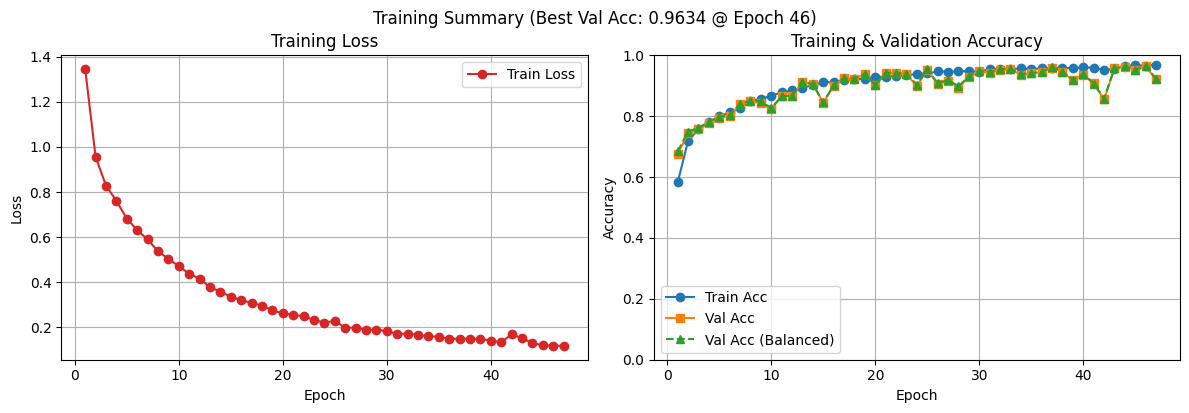

Successfully wrote to log_01-12_22-03.txt


In [83]:
model = train_with_early_stopping(LOAD_FROM_CHECKPOINT=LOAD_CHECKPOINT,
        model_class=Model,
        train_loader=train_loader,
        val_loader=val_loader,
        device= device,
        max_epochs=47,
        patience=15)

**Веса модели после обучения сохранены локально в 'best_model.pth' можно протестировать получившиюся модель и лучшие веса с диска**

## Проверка на тестовой выборке

In [84]:
test_loader = DataLoader(HistologyTorchDataset(Dataset('mytest')))

validate(model, test_loader, device)

Dataset mytest already exists locally. Skipping download.
Loading dataset mytest from npz.
Done. Dataset mytest consists of 4500 images.


(0.9635555555555556, np.float64(0.9635555555555556))

**можно скачать мои лучшие веса и протестировать**

In [85]:
model2 = Model().to(device)
link = 'https://drive.google.com/uc?id=1TbWEVsH8iy_Rb_HTuRsSgyjvXO6LzN9L'

model2.load(link, device)

validate(model2, test_loader, device)

Downloading...
From: https://drive.google.com/uc?id=1TbWEVsH8iy_Rb_HTuRsSgyjvXO6LzN9L
To: /content/model.pth
100%|██████████| 1.17M/1.17M [00:00<00:00, 10.0MB/s]


(0.9697777777777777, np.float64(0.9697777777777777))